<center><h1>Numerical Methods exam</h1></center>
<center><h6>Jérôme Romano</h6></center>


In the following code, I will solve a simplified version of the Real Business Cycle (RBC) model based on the paper "Time to Build and Aggregate Fluctuations" written by Finn E. Kydland and Edward C. Prescott.

My approach involves using both a "manual" and an "automatic" method, where the "linearsolve" package proves to be very useful, in order to solve this RBC model. The purpose is to demonstrate the accuracy of the results obtained through the manual approach.

Subsequently, I plot the impulse responses of the endogenous variables to a one percent shock to the exogenous variable (technology in our case). For completeness, I have also constructed a stochastic simulation to show the potential outcomes over the next periods.

The social planner wants to maximize:

\begin{align}
    E_t[\sum_{i=0}^{\infty} \beta^{i} (U(C_{t+i}) - V(N_{t+i}))] \\
\begin{aligned}
& \begin{cases}
            Y_t = C_t + I_t = A_t K_{t-1}^{\alpha} N_{t}^{1-\alpha_t}\\
            K_t = I_t + (1 - \delta) K_{t-1} \\
            \log(A_t) = (1 - \rho) \log(A^*) + \rho \log(A_{t-1}) + \varepsilon_t
\end{cases}
\end{aligned}
\end{align}

where $C_t$ is consumption, $N_t$ is hours worked, and $β$ is the representative household’s rate of time preference.

Since the natural log in the equation describing the evolution of total factor productivity will create problems for the solution routine later on. So rewrite the equation as:

\begin{align}
    A_{t+1} = A_t^{\rho} e^{\epsilon_{t+1}}
\end{align}


So, the Lagrangean to be solved becomes:

\begin{align}
    L &= E_t\left[\sum_{i=0}^{\infty} \beta^{i} \left[U(C_{t+i}) - V(N_{t+i})\right]\right] + E_t\left[\sum_{i=0}^{\infty} \beta^{i} \lambda_{t+i} \left(A_{t+i}K_{t+i-1}^{\alpha}N_{t+i}^{1-\alpha} + (1 - \delta)K_{t+i-1} - C_{t+i} - K_{t+i}\right)\right]
\end{align}


In [1]:
import numpy as np  # Import the numpy library for numerical computing
import pandas as pd  # Import the pandas library for data manipulation and analysis
import linearsolve as ls  # Import the custom library for solving linear systems
import matplotlib.pyplot as plt  # Import the matplotlib library for plotting
import scipy.optimize  # Import the scipy.optimize module for optimization and root-finding algorithms


In [2]:
# Cancel this cell if you want to re-run the code

import os

cwd = os.getcwd()
figure = '/Exam'

cwd + figure

'C:\\Users\\Jerome Romano\\Numerical Methods/Exam'

#### I. Calibration

The model parameters are adjusted to align with the existing literature. All relevant explanations can be found in the PDF, which covers the significance and function of each parameter.

\begin{align}
    \alpha &= \frac{1}{3} \quad \text{(Capital share in the production function)} \\
    \beta &= 0.99 \quad \text{(Discount factor, representing the preference for future consumption)} \\
    \delta &= 0.015 \quad \text{(Depreciation rate of capital)} \\
    \rho &= 0.95 \quad \text{(Autoregressive parameter for exogenous technology process)} \\
    \eta &= 1.00 \quad \text{(Elasticity of intertemporal substitution in consumption)} \\
    A &= 1.00 \quad \text{(Initial value of the exogenous technology variable)}
\end{align}


In [3]:
# Input model parameters using a pandas Series
parameters = pd.Series(dtype=float)

# Parameter values for the model
parameters['alpha'] = 1/3  # Capital share in the production function
parameters['beta'] = 0.99  # Discount factor, representing the preference for future consumption
parameters['delta'] = 0.015  # Depreciation rate of capital
parameters['rho'] = 0.95  # Autoregressive parameter for exogenous technology process
parameters['eta'] = 1.00  # Elasticity of intertemporal substitution in consumption
parameters['A'] = 1.00  # Initial value of the exogenous technology variable


#### II. Describing the non-linear system of equations for the model

This block plays a crucial role in solving the model.

The Python function below gathers all the equations that describe the model and form the non-linear system. The function receives the variables (both forward, i.e., $x_{t+1}$, and current, i.e., $x_t$), along with the dictionary of parameters, and returns an array containing the values of each equation.

After have solved the first order condition we obtain the following six equations:

\begin{align}
    Y_t &= C_t + I_t                                                      \quad      \text{(Goods market clearing)} \\
    Y_t &= A_t K_{t}^{\alpha} N_t^{1-\alpha}                           \quad      \text{(Production function)} \\
    K_{t+1} &= I_t + (1 - \delta)K_{t}                            \quad      \text{(Capital evolution)}\\
    R_t &= \frac{\alpha Y_t}{K_{t}} + 1 - \delta                     \quad      \text{(Optimal behavior condition for firms)}\\
    C_t^{- \eta} &= \beta E_t ( C_{t+1}^{- \eta} R_{t+1})                       \quad      \text{(Keynes-Ramsey Condition)}\\
    \frac{Y_t}{N_t} &= \frac{a}{1- \alpha} C_t^{\eta}                   \quad      \text{(Optimal hours worked - Labor Supply)} \\
    A_{t+1} &= A_t^\rho                                               \quad      \text{(Exogenous technology process)}
\end{align}


In [4]:
def equations(variables_forward, variables_current, parameters):

    # Extract the parameters
    p = parameters

    # Extract the variables for the current period and the forward period
    fwd = variables_forward
    cur = variables_current

    # Goods market clearing
    market_clearing = cur.c + cur.i - cur.y

    # Production function
    production_function = cur.a * (cur.k ** p.alpha) * cur.n ** (1.00 - p.alpha) - cur.y

    # Capital evolution
    capital_evolution = cur.i + (1 - p.delta) * cur.k - fwd.k
  
    # Household Euler equation or Keynes-Ramsey Condition
    euler_eqn = p.beta * (fwd.c ** -p.eta) * fwd.r - cur.c ** -p.eta

    # Optimal behavior condition for firms (marginal product of capital equals the real interest rate)
    opt_bh = p.alpha * cur.y / cur.k + 1 - p.delta - cur.r

    # Optimal hours worked (labor supply)
    opt_hw = (p.A / (1 - p.alpha)) * cur.c ** p.eta - cur.y / cur.n
    
    # Exogenous technology process
    technology_proc = cur.a ** p.rho - fwd.a

    # Stack equilibrium conditions into a numpy array
    return np.array([
        euler_eqn,
        production_function,
        capital_evolution,
        market_clearing,
        technology_proc,
        opt_bh,
        opt_hw
    ])


#### III. Assessing the model at its steady state


To determine the steady state of the non-linear system, I employed a mixed analytical-numerical approach.

Firstly, it is evident that the technology level's value in the steady state is exogenously provided, eliminating the necessity to include this equation in the equilibrium evaluation. As a result, the system is reduced from 7 to 6 equations.

Next, by substituting the equilibrium values into the remaining equations, I proceed with numerical methods to calculate the steady state values of $y$, $k$, $c$, $n$, $r$, and $i$.

In [5]:
α = 1/3 # Capital share in the production function
β = 0.99 # Discount factor, representing the preference for future consumption
δ = 0.015 # Depreciation rate of capital
ρ = 0.95 # Autoregressive parameter for exogenous technology process
η = 1.00 # Elasticity of intertemporal substitution in consumption
A = 1.00 # Initial value of the exogenous technology variable

Now, I redefine the non-linear system, reducing it only to the variables for which the steady state is yet to be determined. In this context, all variables take the form $x_{t+1} = x_t = \bar{x}$ in the steady state.

I derived it manually

In [6]:
def system(variables):
    # Unpack the variables from the input tuple
    i, n, k, y, r, c = variables

    # Equilibrium conditions

    # Goods market clearing: Total output (y) equals consumption (c) plus investments (i)
    x1 = c + i - y

    # Production function: Total output (y) is a function of capital (k) and labor (n) with the production technology A_0
    x2 = A * (k ** α) * n ** (1 - α) - y

    # Capital evolution: Investments (i) are used to change the capital stock (k) based on the depreciation rate (delta)
    x3 = i - δ * k

    # Optimal behavior condition for firms: The marginal product of capital (alpha * y/k) should equal the real interest rate (r)
    x4 = α * (y / k) + 1 - δ - r

    # Euler equation: Consumption (c) in the current period is determined by the real interest rate (r)
    x5 = c * (β * r - 1)

    # Optimal behavior condition for households: The marginal utility of consumption (c) should equal the marginal disutility of labor (n)
    x6 = (A / (1 - α)) * c ** η - y / n

    # Return the system of equilibrium conditions as a tuple
    return x1, x2, x3, x4, x5, x6


In [7]:
trial = [1, 1, 1, 1, 1, 1]

system(trial)

#The output will be a tuple containing the values of x1, x2, x3, x4, x5, and x6 given the input values [1, 1, 1, 1, 1, 1].
#Each element of the tuple represents the value of the corresponding equilibrium condition.

(1, 0.0, 0.985, 0.31833333333333336, -0.010000000000000009, 0.4999999999999998)

In [8]:
# Find the root of the system of equations using scipy.optimize.root
sol = scipy.optimize.root(system, trial).x

# Check if the solution satisfies the equilibrium conditions by plugging it back into the system
# Round the results to 9 decimal places for comparison
result = np.round(system(sol), 9)

# Print the result
print(result)


[ 0. -0.  0. -0.  0. -0.]


In [9]:
# The sol array represents the values of the variables at the equilibrium point
i, n, k, y, r, c = sol

# i: Investment level at equilibrium
# n: Labor supply at equilibrium
# k: Capital stock at equilibrium
# y: Total output (GDP) at equilibrium
# r: Real interest rate at equilibrium
# c: Consumption level at equilibrium

sol


array([ 0.60430284,  0.83249581, 40.28685615,  3.03372235,  1.01010101,
        2.42941951])

#### Please
Let's remember the values we obtained through Scipy for the variables in the steady state:

$i$ = 0.60430284

$n$ = 0.83249581

$k$ = 40.28685615

$y$ = 3.03372235

$r$ = 1.01010101

$c$ = 2.42941951

These are the steady state values of the variables to be determined.

#### IV. Setting up the model

The model is now prepared for initialization.

I specify one predetermined variable, which will automatically be the first one described: $a$.

In [10]:
# Initialize the model using the linearsolve package

# 1) The definition of the non-linear system
# The 'equations' argument refers to the previously defined 'equations' function,
# which computes the equilibrium conditions for the economic model.

# 2) The number of predetermined (state) variables
# The 'n_states' argument specifies the number of predetermined variables in the model.
# In this case, there are 2 predetermined variables.

# 3) The list of variables making up the model
# The 'var_names' argument is a list that defines the names of the model variables.
# The variables are defined as ['a', 'k', 'c', 'y', 'i', 'r', 'n'].

# 4) A list of shocks (one for each state variable)
# The 'n_exo_states' argument specifies the number of exogenous state variables (shocks) in the model.
# In this case, there is 1 exogenous state variable (shock).

# 5) The list of parameters
# The 'parameters' argument refers to the previously defined 'parameters' Series,
# which contains the values of the model parameters.

# Creating the model instance with the specified arguments
rbc = ls.model(equations=equations,
               n_states=2,
               n_exo_states=1,
               var_names=['a', 'k', 'c', 'y', 'i', 'r', 'n'],
               parameters=parameters)


I create an array containing the steady state values obtained above, and then I verify that it satisfies the larger non-linear system.

In [11]:
# Manually set the steady-state values for the model variables
# The steady-state values represent the values of the variables at equilibrium

# Create a dictionary containing the steady-state values for each variable
rbc.ss = {
    'a': 1.000000,  # Steady-state value of exogenous technology (A)
    'k': 40.28685615,  # Steady-state value of capital stock (k)
    'c': 2.429420,  # Steady-state value of consumption (c)
    'y': 3.03372235,  # Steady-state value of total output (GDP) (y)
    'i': 0.60430284,  # Steady-state value of investments (i)
    'r': 1.01010101,  # Steady-state value of real interest rate (r)
    'n': 0.83249581  # Steady-state value of labor supply (n)
}

# Convert the dictionary to a pandas Series and assign it to the rbc.ss attribute
rbc.ss = pd.Series(rbc.ss)


In [12]:
equations(rbc.ss, rbc.ss, parameters)
# Call the 'equations' function with the steady-state values provided as input for both variables_forward and variables_current
# Also, pass the 'parameters' to the function

array([-4.11620737e-11, -6.44142562e-09, -2.24999752e-09,  4.90000000e-07,
        0.00000000e+00,  1.05335074e-10,  7.28046066e-07])

In [13]:
# Set the steady-state values for the model 'rbc' using the 'set_ss' method

# The input list contains the steady-state values for the model variables in the following order:
# [a, k, c, y, i, r, n]

# Call the 'set_ss' method of the 'rbc' model and pass the steady-state values as input
rbc.set_ss([1.000000, 40.28685615, 2.429420, 3.03372235, 0.60430284, 1.01010101, 0.83249581])


In [14]:
# This is the steady state of the model

#The provided code rbc.ss retrieves the steady-state values of the model variables from the rbc model instance.
#After setting the steady-state values using rbc.set_ss as mentioned in the previous step,
#calling rbc.ss will give us access to the steady-state values. Here are the steady-state values of the model variables:

rbc.ss

a     1.000000
k    40.286856
c     2.429420
y     3.033722
i     0.604303
r     1.010101
n     0.832496
dtype: float64

The verification is further validated using a built-in method of the package.

Please note that the two False results are attributed to the method's low tolerance. Nevertheless, it's worth mentioning that the first equation in the steady state is approximately 0.0001, indicating a very close proximity to 0.

In [15]:
rbc.check_ss()

[ True  True  True False  True  True False]


For completeness, I have also computed the result using the computational package "linsolve." As we can observe, the results obtained are identical to the ones obtained earlier through the "manual" method.

In [16]:
# Compute the steady-state values of the model using the 'linsolve' package
# The 'compute_ss' method takes the initial guess 'guess' as input and automatically re-computes the steady-state

# 'guess' is a list containing the initial guess for the steady-state values of the model variables
guess = [1, 1, 1, 1, 1, 1, 1]

# Call the 'compute_ss' method of the 'rbc' model and pass the 'guess' as input
# The method will compute the steady-state values and update 'rbc.ss' with the computed values
rbc.compute_ss(guess)

# Print the computed steady-state values
print(rbc.ss)


a     1.000000
k    40.286856
c     2.429420
y     3.033722
i     0.604303
r     1.010101
n     0.832496
dtype: float64


#### V. Linearizing Non-linear Systems and Modeling with State Space Representation

The package possesses the capability to log-linearly approximate the system around its steady state, generating two matrices, $A$ and $B$, which enable the model to be represented as follows:

$$A \mathbb{E}[x_{t+1}] = B x_t$$

The process for obtaining the state space representation is described in the provided PDF. Specifically, the procedure involves implementing the algorithm described in Chapter 2 of "Structural Macroeconometrics" by DeJong and Dave.

Although I do not execute all the steps personally, it is essential to acknowledge that this routine is entirely built upon the foundation of the aforementioned literature.

In [17]:
# Perform log-linearization of the model equations around the non-stochastic steady state
rbc.log_linear_approximation()

# Compute matrices A and B

# Matrix A collects the derivative of the log-linearized equations w.r.t. the forward variables
# holding the current ones fixed at the steady state.
# The matrix A represents the coefficients of the forward variables (variables at t+1) in the log-linearized system.

# Matrix B collects the derivative of the log-linearized equations w.r.t. the current variables
# holding the forward ones fixed at the steady state.
# The matrix B represents the coefficients of the current variables (variables at t) in the log-linearized system.

# Print the matrices A and B after rounding the values to four decimal places
print('The matrix A:\n\n', np.around(rbc.a, 4), '\n\n')
print('The matrix B:\n\n', np.around(rbc.b, 4))


The matrix A:

 [[  0.       0.      -0.4116   0.       0.       0.4116   0.    ]
 [  0.       0.       0.       0.       0.       0.       0.    ]
 [  0.     -40.2869   0.       0.       0.       0.       0.    ]
 [  0.       0.       0.       0.       0.       0.       0.    ]
 [ -1.       0.       0.       0.       0.       0.       0.    ]
 [  0.       0.       0.       0.       0.       0.       0.    ]
 [  0.       0.       0.       0.       0.       0.       0.    ]] 


The matrix B:

 [[-0.00000e+00 -0.00000e+00 -4.11600e-01 -0.00000e+00 -0.00000e+00
  -0.00000e+00 -0.00000e+00]
 [-3.03370e+00 -1.01120e+00 -0.00000e+00  3.03370e+00 -0.00000e+00
  -0.00000e+00 -2.02250e+00]
 [-0.00000e+00 -3.96826e+01 -0.00000e+00 -0.00000e+00 -6.04300e-01
  -0.00000e+00 -0.00000e+00]
 [-0.00000e+00 -0.00000e+00 -2.42940e+00  3.03370e+00 -6.04300e-01
  -0.00000e+00 -0.00000e+00]
 [-9.50000e-01 -0.00000e+00 -0.00000e+00 -0.00000e+00 -0.00000e+00
  -0.00000e+00 -0.00000e+00]
 [-0.00000e+00  2.5100

#### VI. Solving the System Using Klein's Method: An Application to Dynamic Econometric Models

The model can now be resolved using the Klein method, once more utilizing the package's built-in functionality.

In [18]:
# Solve the model using the Klein method with matrices A and B
rbc.solve_klein(rbc.a, rbc.b)

# Display the output - The output consists of two matrices:

# Matrix F describes the policy function, mapping current states into current controls (jumping variables).
# The matrix F represents the coefficients that link the current control variables to the current state variables.
# It describes how the model's control variables respond to changes in the current state variables.

# Matrix P describes the transition function, mapping current states into forward states.
# The matrix P represents the coefficients that link the forward state variables to the current state variables.
# It describes how the model's forward state variables evolve in response to changes in the current state variables.

# Print the matrices F and P after rounding the values to four decimal places
print('The matrix F:\n\n', np.around(rbc.f, 4), '\n\n')
print('The matrix P:\n\n', np.around(rbc.p, 4))


The matrix F:

 [[ 0.4337  0.5104]
 [ 2.1326 -0.0208]
 [ 8.9627 -2.1565]
 [ 0.053  -0.0254]
 [ 1.6989 -0.5312]] 


The matrix P:

 [[0.95   0.    ]
 [0.1344 0.9527]]


The initial row of matrix $P$ describes the dynamic behavior of $A_t$ as an autoregressive process. Remarkably, the matrix entries precisely follow the AR(1) process assumed in the model. This clear alignment serves as compelling evidence that the solution is accurate and reliable.

#### VII.  Impact of Technological Shock: Impulse Response Function

Continuing with the identical steps, I now investigate the impulse response function in response to a technological shock.

In [19]:
# Compute impulse responses and plot

# The 'impulse' method computes the impulse responses of the model variables to shocks.
# The method takes the following arguments:

# T: Number of periods for which to compute the impulse responses.
# t0: Starting period for the impulse response simulation. In this case, t0 is set to 0.
# shocks: A list of shocks to apply to the exogenous variables. In this case, a 0.01 unit shock is applied to the exogenous technology variable 'a'.
# percent: If True, the impulse responses will be reported in percentage changes. If False, they will be reported in level changes.

# The impulse responses show how each model variable responds over time to the exogenous technology shock.
# The responses are typically reported as deviations from the steady-state values.

rbc.impulse(T=50, t0=0, shocks=[0.01], percent=True)


In [20]:
# Print impulse responses to a 0.01 unit shock to A

# The 'irs' attribute of the 'rbc' model contains the impulse response results.
# 'irs' stands for impulse response simulations.

# The 'irs' attribute is a dictionary, and each key corresponds to a shock variable.
# In this case, 'e_a' is the key representing the impulse response to a shock in the exogenous technology variable 'a'.

# The 'head()' method is used to display the first few rows of the impulse response simulation results.

print('Impulse responses to a 0.01 unit shock to A:\n\n', rbc.irs['e_a'].head())


Impulse responses to a 0.01 unit shock to A:

    e_a         a         k         c         y         i         r         n
0  1.0  1.000000  0.000000  0.433685  2.132630  8.962735  0.052996  1.698946
1  0.0  0.950000  0.134441  0.480620  2.023200  8.224682  0.046936  1.542580
2  0.0  0.902500  0.255795  0.521960  1.919374  7.537258  0.041340  1.397413
3  0.0  0.857375  0.365017  0.558138  1.820865  6.897282  0.036178  1.262727
4  0.0  0.814506  0.463001  0.589559  1.727402  6.301763  0.031420  1.137843


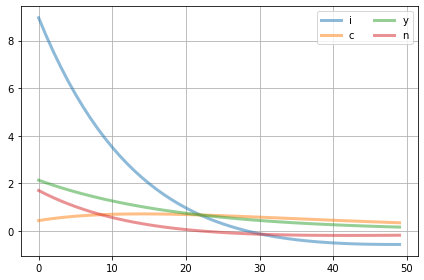

In [21]:
# Plot 1: Impulse responses of 'i', 'c', 'y', and 'n' to a 0.01 unit shock in 'a'

# Plot the impulse responses of 'i', 'c', 'y', and 'n' to the shock in 'a'
rbc.irs['e_a'][['i', 'c', 'y', 'n']].plot(lw='3', alpha=0.5, grid=True)

# Add a legend to the plot, with the labels located in the upper right corner and organized in 2 columns
plt.legend(loc='upper right', ncol=2)

plt.tight_layout()

plt.savefig('irf_technology_0')

plt.show()


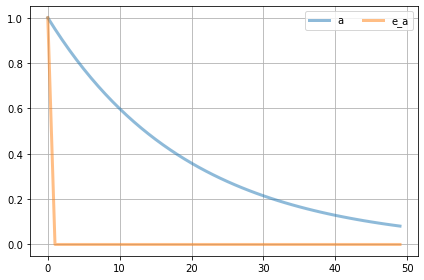

In [22]:
# Plot 2: Impulse responses of 'a' and 'e_a' to a 0.01 unit shock in 'a'

# Plot the impulse responses of 'a' and 'e_a' to the shock in 'a'
rbc.irs['e_a'][['a', 'e_a']].plot(lw='3', alpha=0.5, grid=True)

# Add a legend to the plot, with the labels located in the upper right corner and organized in 2 columns
plt.legend(loc='upper right', ncol=2)

plt.tight_layout()

plt.savefig('irf_technology_1')

plt.show()


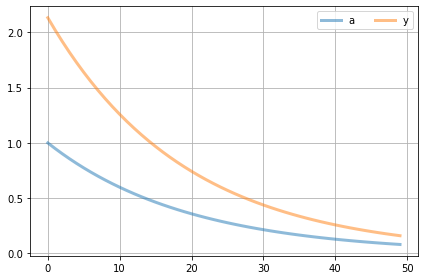

In [23]:
# Plot 3: Impulse responses of 'a' and 'y' to a 0.01 unit shock in 'a'

# Plot the impulse responses of 'a' and 'y' to the shock in 'a'
rbc.irs['e_a'][['a', 'y']].plot(lw='3', alpha=0.5, grid=True)

# Add a legend to the plot, with the labels located in the upper right corner and organized in 2 columns
plt.legend(loc='upper right', ncol=2)

plt.tight_layout()

plt.savefig('irf_technology_2')

plt.show()


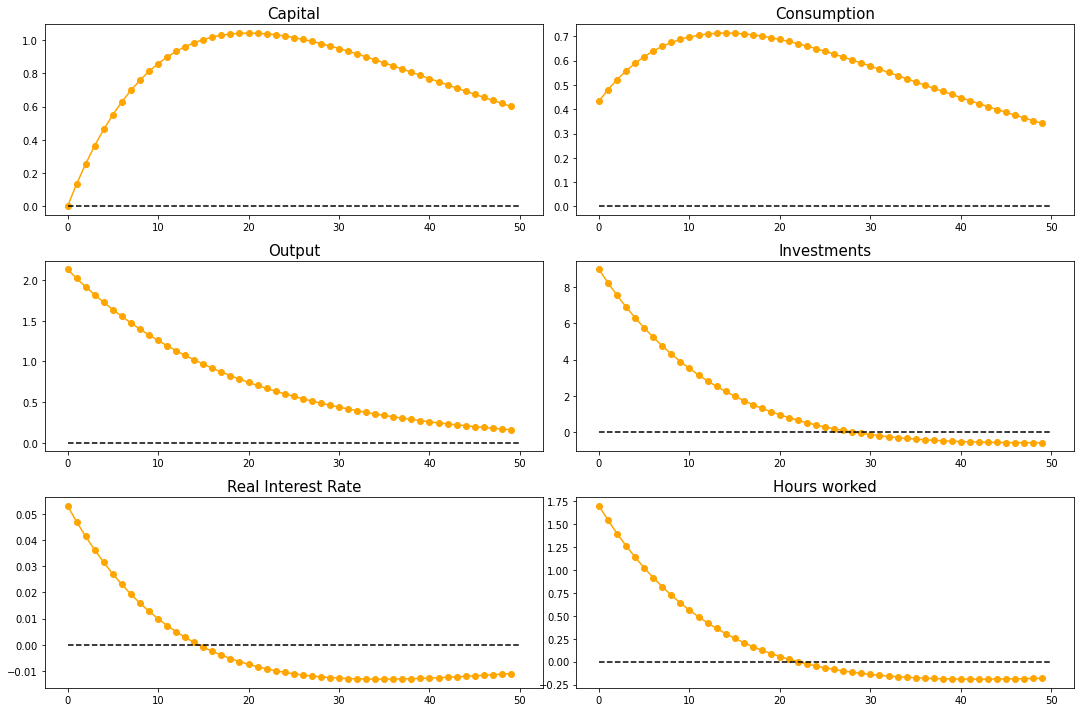

In [24]:
# Define the number of periods for the impulse responses
T = 50

# Define the list of model variables to plot
variables = ['k', 'c', 'y', 'i', 'r', 'n']

# Define the titles for each subplot
titles = [r'Capital', r'Consumption', r'Output', r'Investments', r'Real Interest Rate', r'Hours worked']

# Create a figure with 3 rows and 2 columns of subplots, each subplot size is (15, 10)
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(15, 10))

# Arrange the subplots in a 3x2 grid
axes = [ax1, ax2, ax3, ax4, ax5, ax6]

# Loop through each model variable and its corresponding title
for (i, variable, title) in list(zip(axes, variables, titles)):
    # Plot the impulse responses of the variable to the shock in 'a' using orange color and connecting data points with lines
    i.plot(rbc.irs['e_a'][variable], 'o-', color='orange')
    
    # Set the title for the subplot with font size 15
    i.set_title(title, fontsize=15)
    
    # Add a horizontal dashed line at y=0 for reference
    i.hlines(0, 0, T, 'k', linestyle='dashed')
    
    # Set tick label font size to 10 for both x and y axes
    i.tick_params(axis='both', which='major', labelsize=10)

# Adjust the layout of the subplots to prevent overlapping
fig.tight_layout()

# Save the figure as 'irf_tech.png'
plt.savefig('irf_tech.png')

# Display the plot
plt.show()


Now, since after an impulse responde all the variables should converge to the steady-state level "0". I increase the periods "T" in order to achieve this result

In [25]:
rbc.impulse(T=200, t0=0, shocks=[0.01], percent=True)

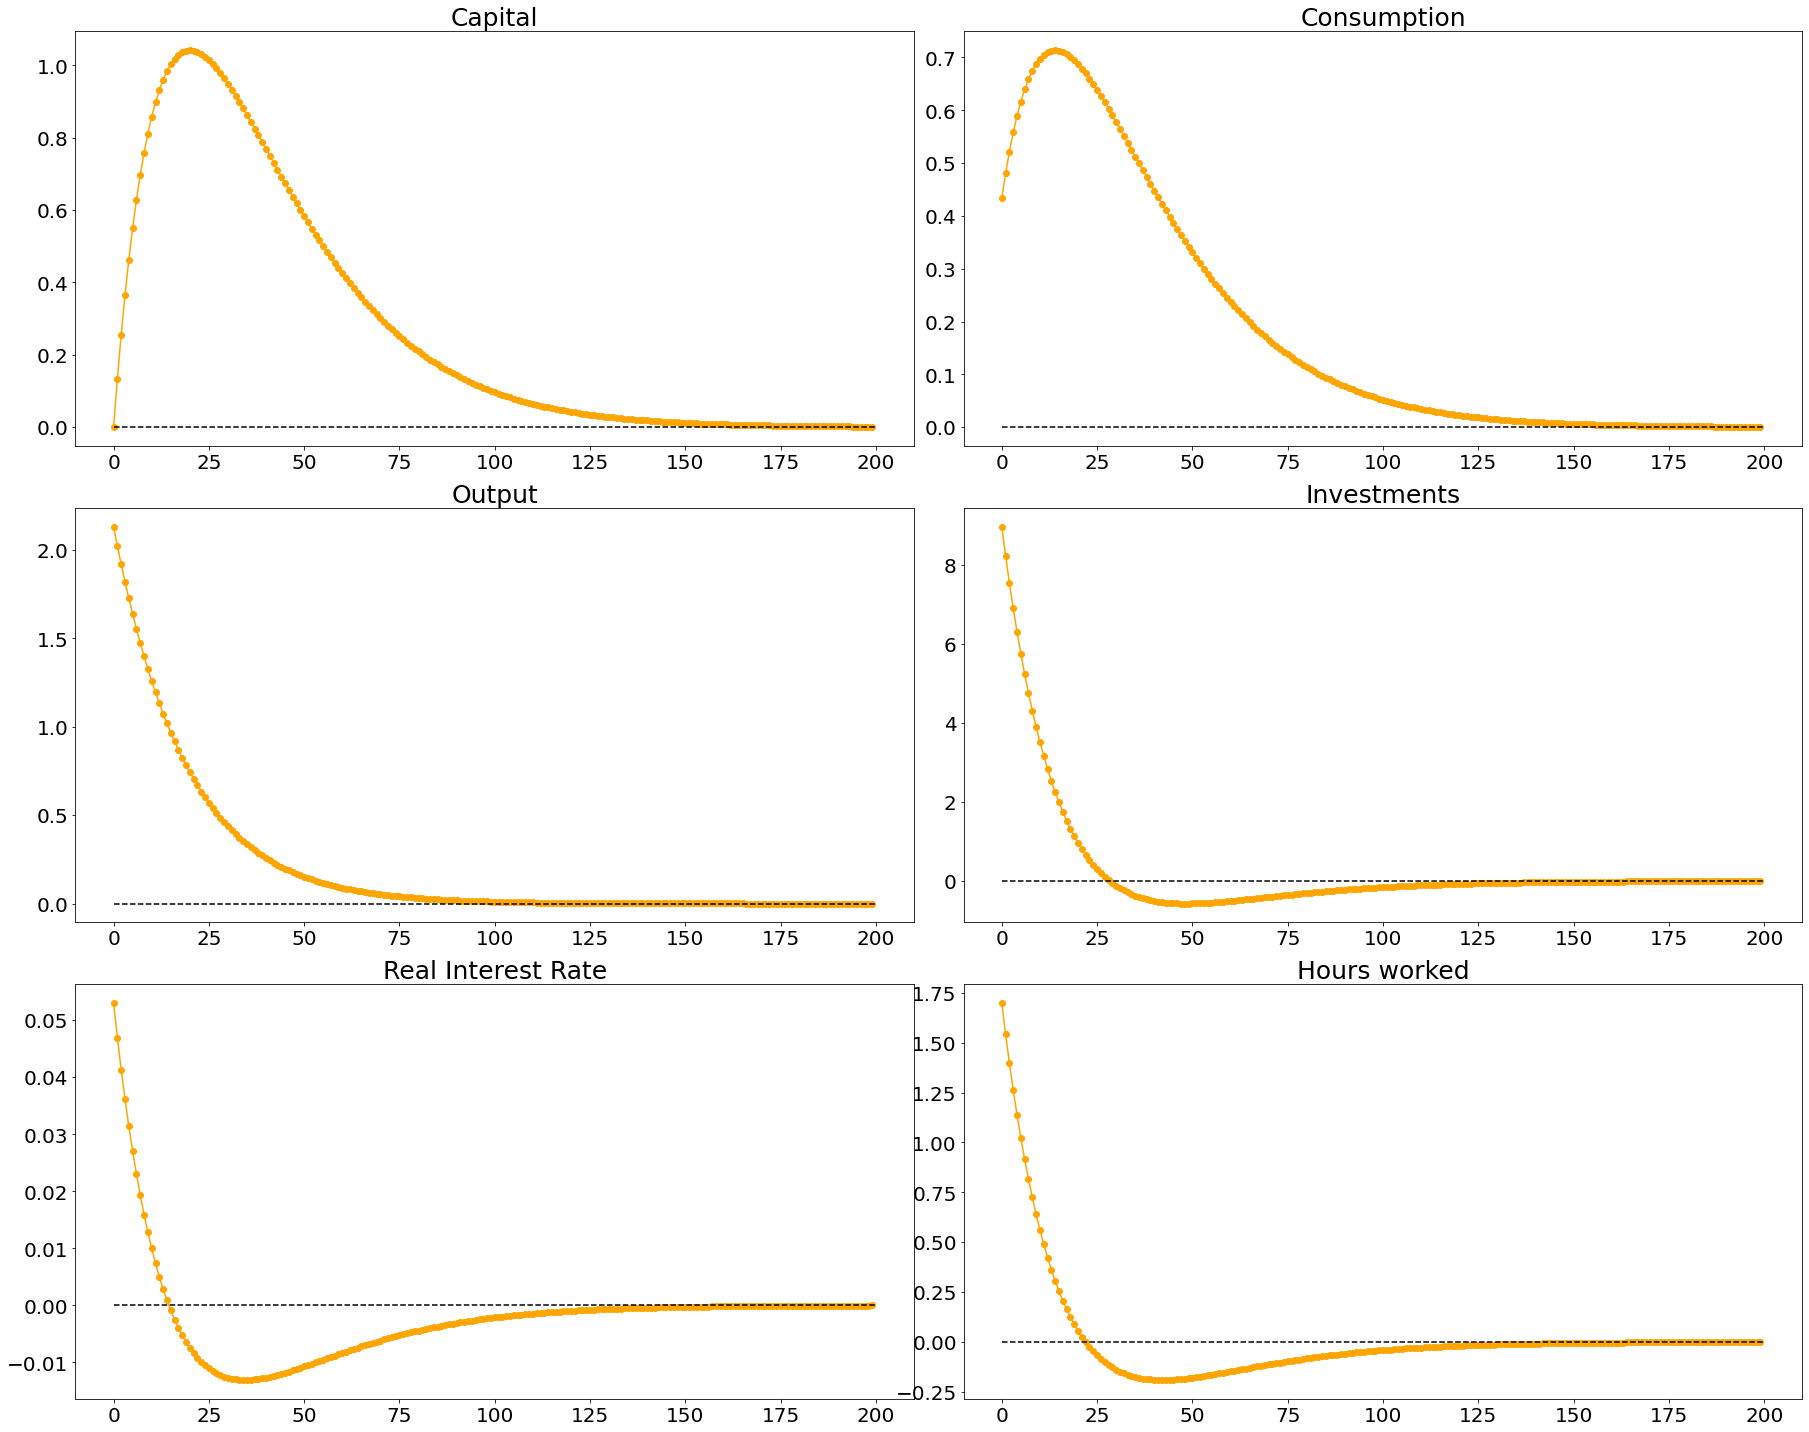

In [26]:
# Define the number of periods for the impulse responses
T = 200

# Define the list of model variables to plot
variables = ['k', 'c', 'y', 'i', 'r', 'n']

# Define the titles for each subplot
titles = [r'Capital', r'Consumption', r'Output', r'Investments', r'Real Interest Rate', r'Hours worked']

# Create a figure with 3 rows and 2 columns of subplots, each subplot size is (25, 20)
fig, axes = plt.subplots(3, 2, figsize=(25, 20))

# Flatten the 3x2 array of subplots to a 1D array for easier iteration
axes = axes.flatten()

# Loop through each model variable and its corresponding title
for (i, variable, title) in list(zip(axes, variables, titles)):
    # Plot the impulse responses of the variable to the shock in 'a' using orange color and connecting data points with lines
    i.plot(rbc.irs['e_a'][variable], 'o-', color='orange')
    
    # Set the title for the subplot with a larger font size (25)
    i.set_title(title, fontsize=25)
    
    # Add a horizontal dashed line at y=0 for reference
    i.hlines(0, 0, T, 'k', linestyle='dashed')
    
    # Increase the font size of tick labels on both axes
    i.tick_params(axis='both', which='major', labelsize=20)

# Adjust the layout of the subplots to prevent overlapping
fig.tight_layout()

# Display the plot
plt.show()

#### VIII.  Stochastic simulation: Cycles with Volatile Investment

I create a 200 period simulation. The standard deviation of the shock to $a$ is set to 0,17 . The seed for the numpy random number generator is set to 21, because it was the most similar the one of the paper.

In [27]:
# Perform stochastic simulation of the model for 200 periods
rbc.stoch_sim(T=200, drop_first=0, cov_mat=np.array([0.17**2]), seed=21, percent=True)

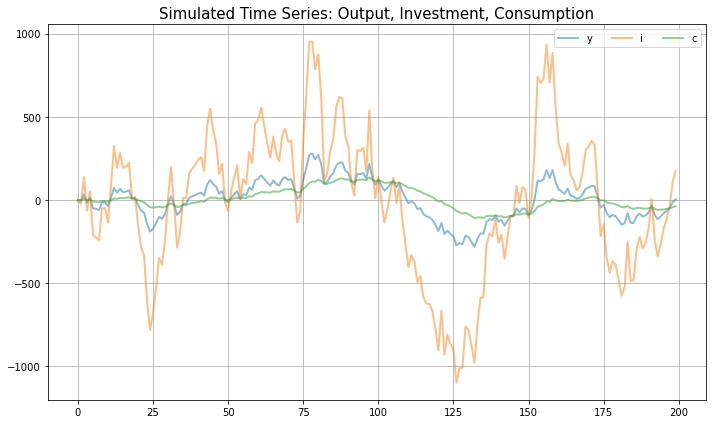

In [28]:
# Create a figure for the first plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the simulated time series for 'y', 'i', and 'c' with orange color, connecting data points with lines
rbc.simulated[['y', 'i', 'c']].plot(ax=ax, lw='2', alpha=0.5, grid=True)

# Set the title for the plot
ax.set_title('Simulated Time Series: Output, Investment, Consumption', fontsize=15)

# Add a legend to the plot, with labels located in the upper right corner, and organized in 4 columns
ax.legend(loc='upper right', ncol=4)

# Adjust the layout of the plot
fig.tight_layout()

# Save the plot as 'irf_sim_yic.png'
plt.savefig('irf_sim_yic.png')

# Display the plot
plt.show()


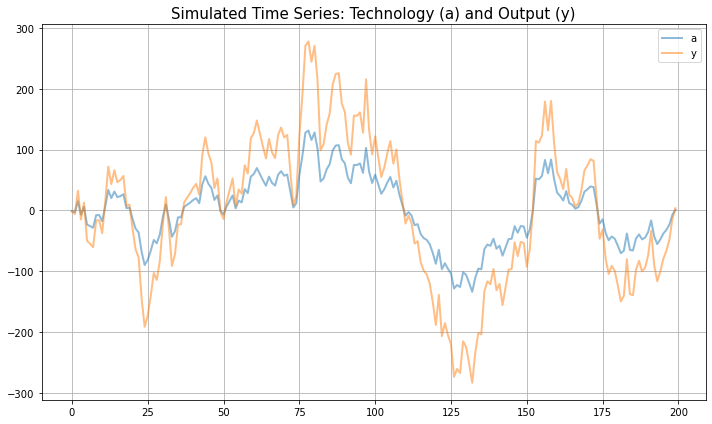

In [29]:
# Create a figure for the second plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the simulated time series for 'a' and 'y' with blue color, connecting data points with lines
rbc.simulated[['a', 'y']].plot(ax=ax, lw='2', alpha=0.5, grid=True)

# Set the title for the plot
ax.set_title('Simulated Time Series: Technology (a) and Output (y)', fontsize=15)

# Add a legend to the plot, with labels located in the upper right corner, and organized in 1 column
ax.legend(loc='upper right', ncol=1)

# Adjust the layout of the plot
fig.tight_layout()

# Save the plot as 'irf_sim_ay.png'
plt.savefig('irf_sim_ay.png')

# Display the plot
plt.show()
